# Artificial intelligence in bioinformatics

Dataset analysed during the certificate in "Artificial intelligence in bioinformatics" (by FutureLearn) regarding proteins related to diabetic and non-diabetic patients.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.utils import class_weight

import xgboost as xgb
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

pd.set_option('future.no_silent_downcasting', True)

2025-09-17 15:53:48.703874: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def load(filename):
    #read the file and skip lines starting with @
    with open(filename+'.arff', 'r') as f:
        lines = [line for line in f if not line.strip().startswith('@') and line.strip()]
    
    #convert to pandas dataframe
    from io import StringIO
    data_str = '\n'.join(lines)
    df = pd.read_csv(StringIO(data_str), header=None)

    #replace yes with 1 and no with 0
    df = df.replace({'yes': 1, 'no': 0})

    #return dataframe
    return df

In [3]:
class EDA:
    def __init__(self, df):
        #set amino name
        col = ['A', 'R', 'N', 'D', 'C', 
               'Q', 'E', 'G', 'H', 'I', 
               'L', 'K', 'M', 'F', 'P', 
               'S', 'T', 'W', 'Y', 'V','diabete'] 
        #check if columns have names
        if df.columns.isnull().any() or df.columns[0] == 0:
            #assign default names col_0, col_1, ...
            df.columns = [col[i] for i in range(df.shape[1])]
        
        #store a copy of the dataframe
        self.df = df.copy()
        
        #define target as the last column
        self.target = df.columns[-1]
        
        #define features as all columns except target
        self.features = df.columns[:-1]

    def overview(self):
        #print shape and basic info
        print("shape:", self.df.shape)
        print("\ndata types:\n", self.df.dtypes)
        print("\nfirst 5 rows:\n", self.df.head())
        print("\nsummary statistics:\n", self.df.describe())

    def missing_values(self):
        #check for missing values
        missing = self.df.isnull().sum()
        missing = missing[missing>0]
        if missing.empty:
            print("no missing values found")
        else:
            print("missing values per column:\n", missing)
            sns.heatmap(self.df.isnull(), cbar=False)
            plt.title("missing values heatmap")
            plt.show()

    def histograms(self):
        #histograms of numeric features
        self.df[self.features].hist(figsize=(10,6), bins=20)
        plt.suptitle("feature distributions")
        plt.tight_layout()
        plt.show()

    def boxplots(self):
        #boxplots of numeric features
        for col in self.features:
            if np.issubdtype(self.df[col].dtype, np.number):
                sns.boxplot(y=self.df[col])
                plt.title(f"boxplot of {col}")
                plt.show()

    def correlation_matrix(self):
        #correlation matrix for numeric features
        corr = self.df[self.features].corr()
        plt.figure(figsize=(12,10))
        sns.heatmap(corr, annot=True,fmt='.2f', cmap='coolwarm')
        plt.title("correlation matrix")
        plt.show()

    def target_distribution(self):
        #plot target distribution
        if np.issubdtype(self.df[self.target].dtype, np.number):
            sns.histplot(self.df[self.target], kde=True)
        else:
            sns.countplot(x=self.df[self.target])
        plt.title(f"distribution of target: {self.target}")
        plt.show()

In [4]:
def xgb_analysis(X_train,y_train,X_test,y_test):

    #define modle
    model = xgb.XGBClassifier(eval_metric='logloss', random_state=42)

    #train the model
    model.fit(X_train, y_train)
    
    #make predictions on train set
    y_train_pred = model.predict(X_train)
    #make predictions on test set
    y_test_pred = model.predict(X_test)

    print('Train accuracy =', accuracy_score(y_train, y_train_pred))
    print('Test accuracy =', accuracy_score(y_test, y_test_pred))

    #compute confusion matrix
    cm = confusion_matrix(y_test,y_test_pred)
    
    #plot confusion matrix
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0,1], yticklabels=[0,1])
    plt.xlabel('predicted')
    plt.ylabel('actual')
    plt.show()

## Analysis on AAC data

In [5]:
#load train and test data
train = load('et_tp.AAC.train')
test = load('et_tp.AAC.test')

In [6]:
eda = EDA(train)
#eda.overview()

In [7]:
eda.missing_values()

no missing values found


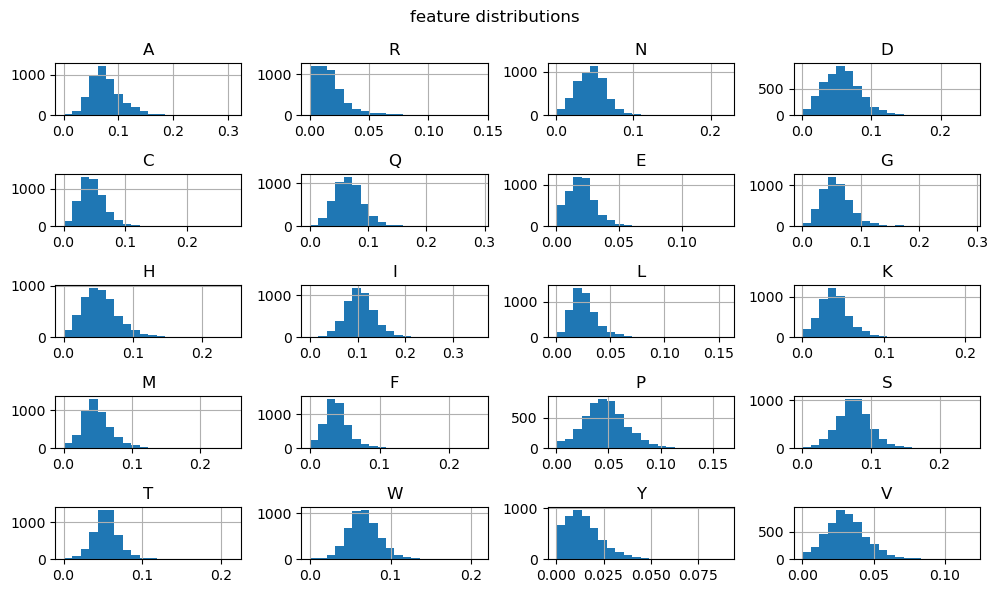

In [8]:
eda.histograms()

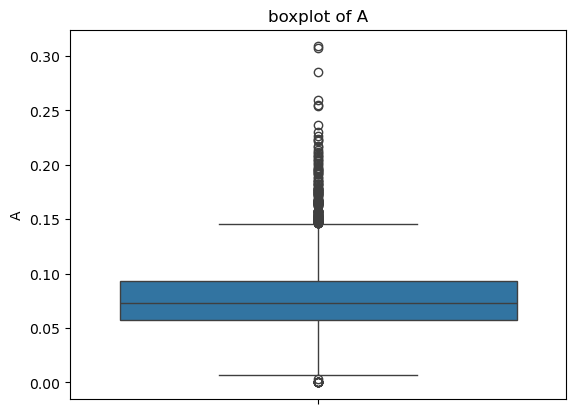

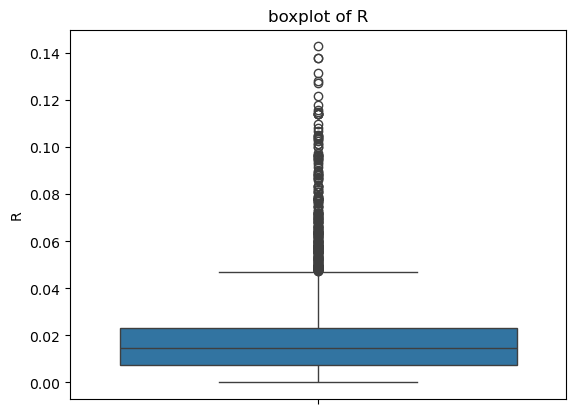

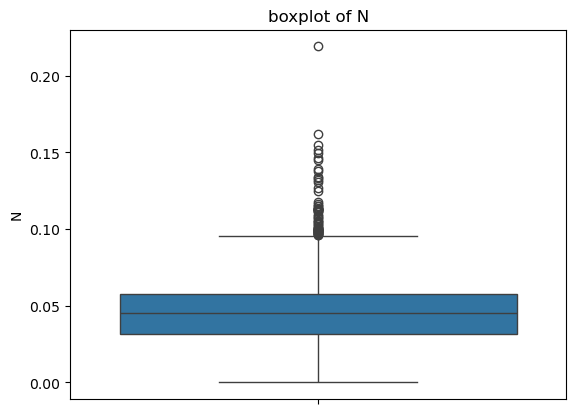

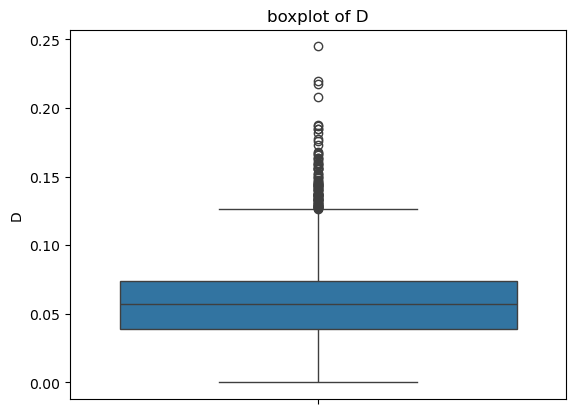

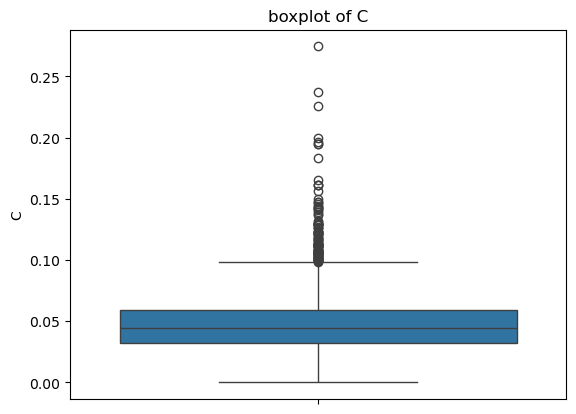

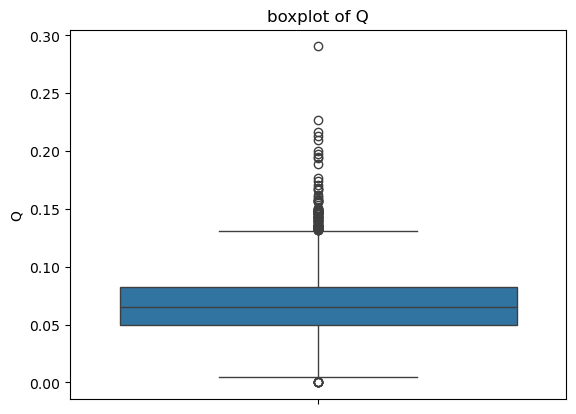

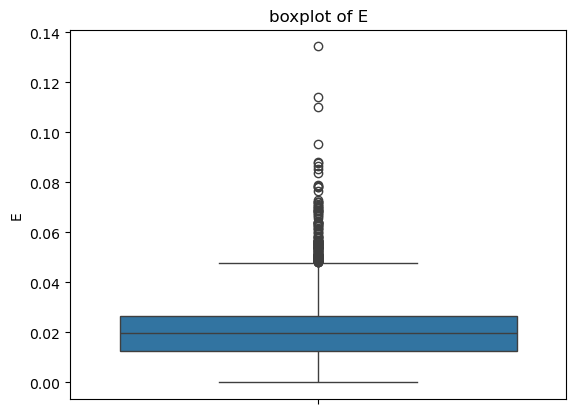

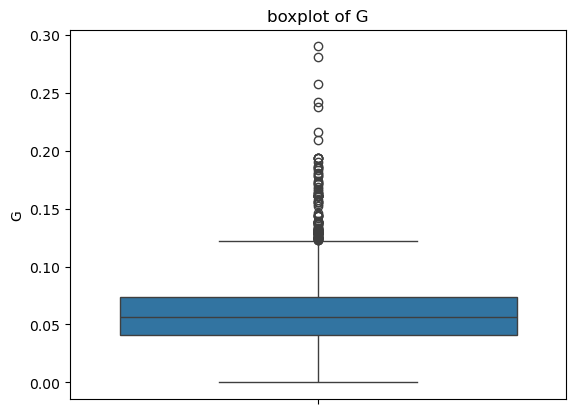

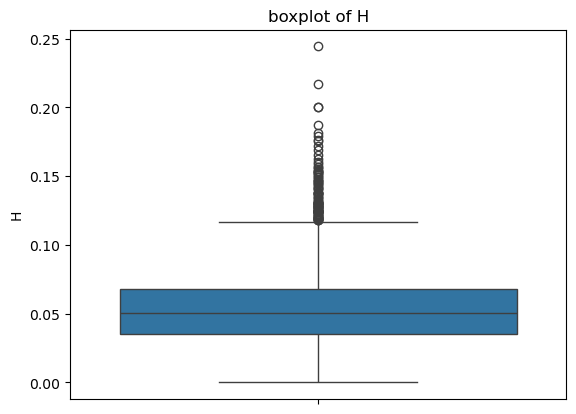

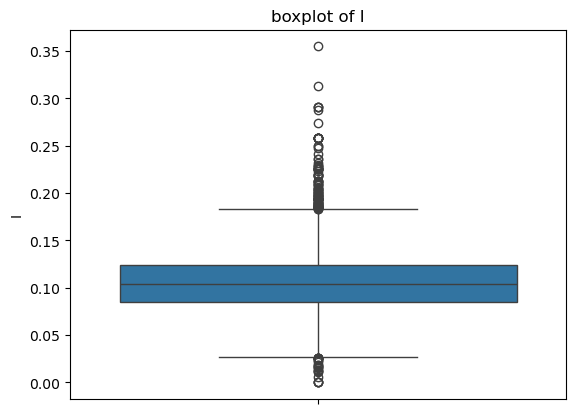

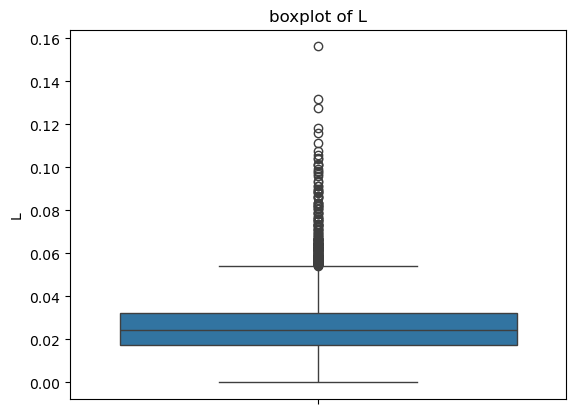

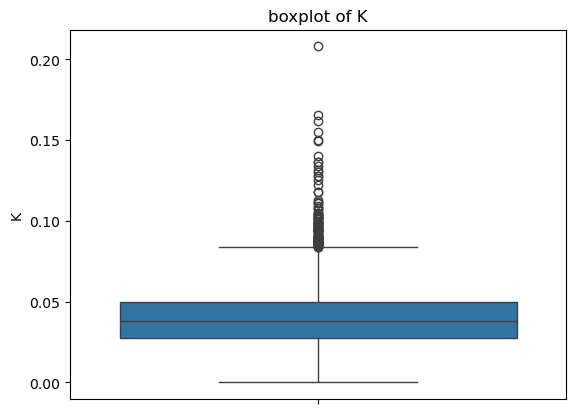

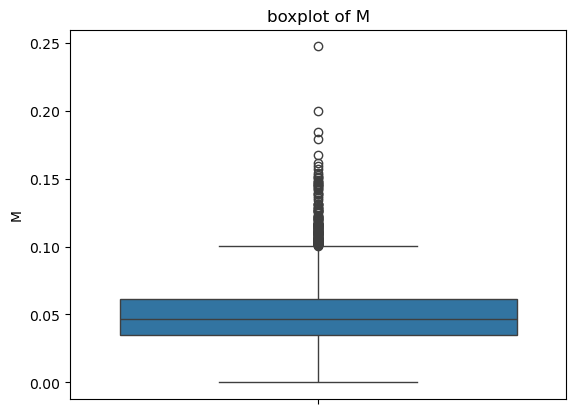

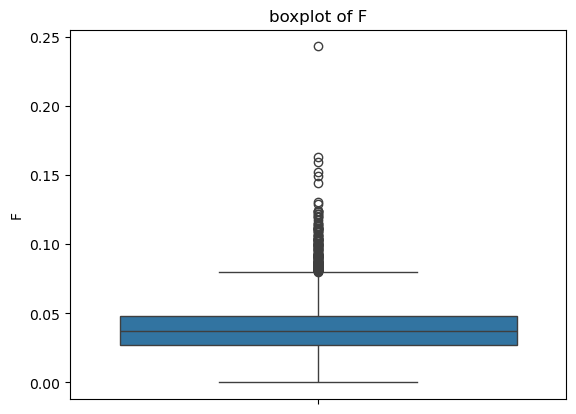

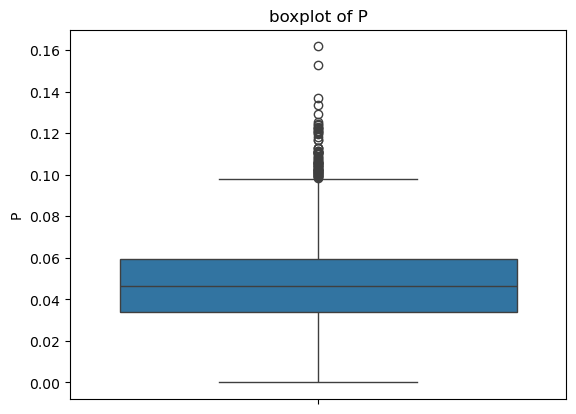

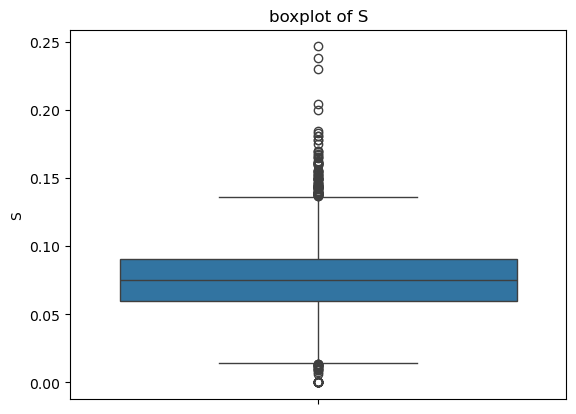

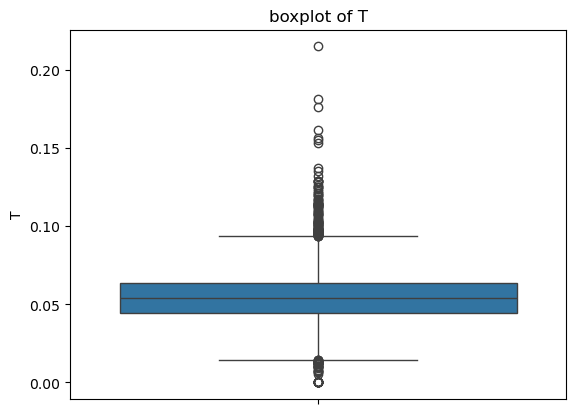

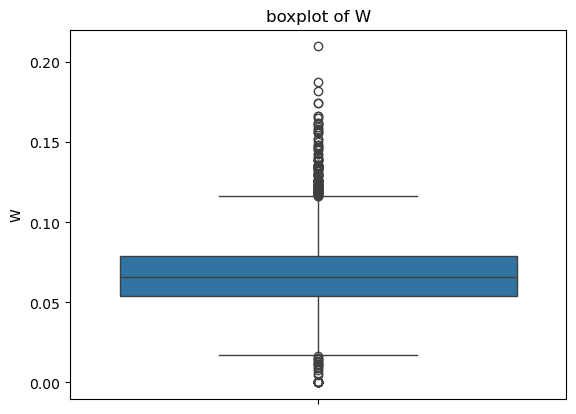

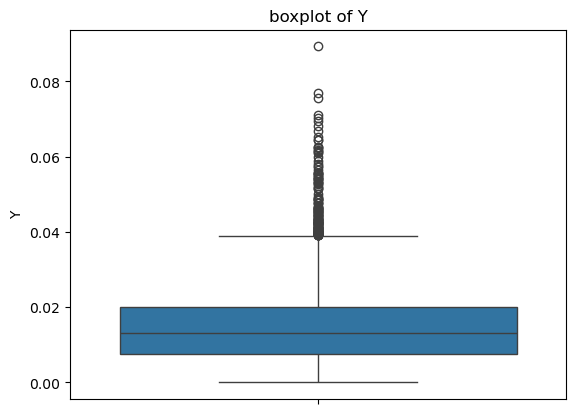

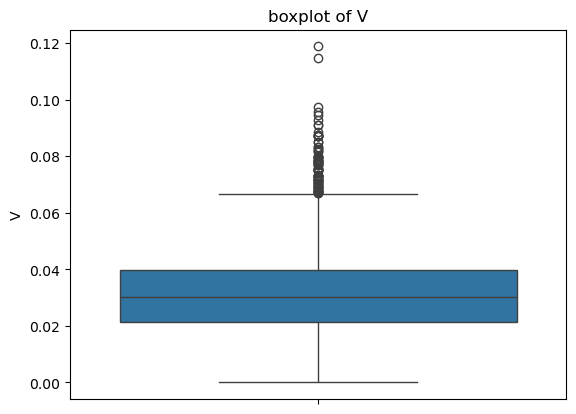

In [9]:
eda.boxplots()

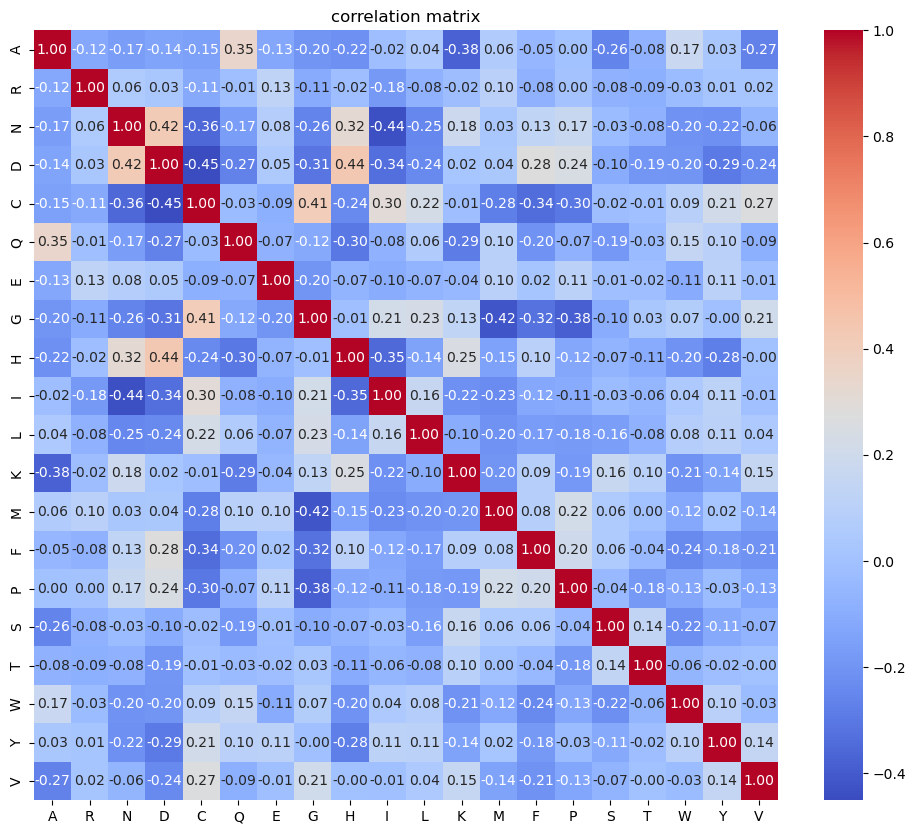

In [10]:
eda.correlation_matrix()

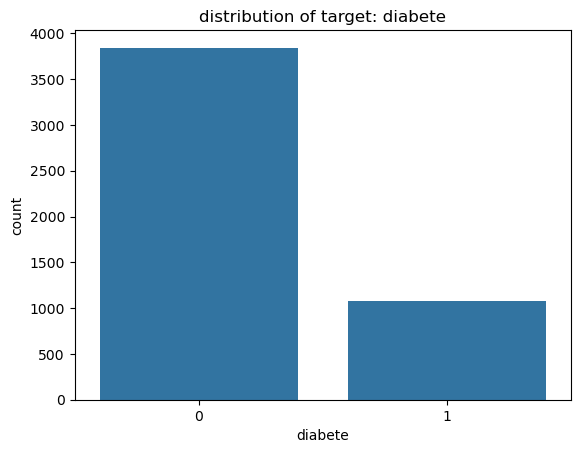

In [11]:
eda.target_distribution()

The histograms of the features, representing the amino acids, reveal clear peaks with tails that gradually decrease, resembling a Gaussian-like distribution. This suggests that, for most amino acids, the majority of observations are concentrated around a central value, while extreme values are less frequent. However, there are numerous outliers present across nearly all amino acid features, indicating that some protein sequences exhibit atypical amino acid compositions.

Furthermore, analysis of the correlation matrix shows that certain amino acids exhibit noticeable correlations. For example, amino acids D (Aspartic acid) and N (Asparagine) are positively correlated, likely due to their similar chemical properties and roles in protein structure and function, which may lead them to co-occur or substitute for each other in specific protein contexts.

Finally, the dataset is unbalanced, with a higher number of samples from individuals with diabetes compared to non-diabetic subjects. This imbalance should be taken into account in subsequent analyses or predictive modeling, as it may bias the results and affect the performance of machine learning classifiers.

In [12]:
X_train = train.iloc[:,:-1].values
y_train = train.iloc[:,-1].values
X_test = test.iloc[:,:-1].values
y_test = test.iloc[:,-1].values

#convert target to integers
y_train = y_train.astype(int)
y_test = y_test.astype(int)

Train accuracy = 0.9997966653111021
Test accuracy = 0.8267716535433071


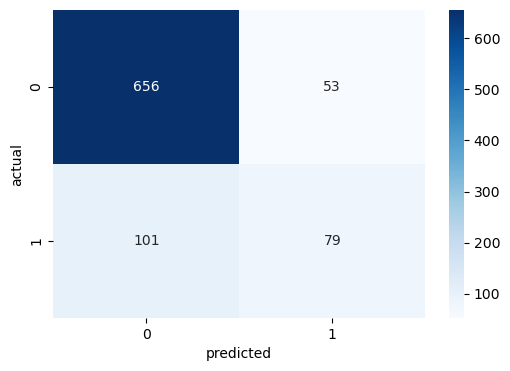

In [13]:
xgb_analysis(X_train,y_train,X_test,y_test)

We observe a clear case of overfitting on the training set, as evidenced by the substantially higher training accuracy compared to the test accuracy. This indicates that the model has learned the training data very well but struggles to generalize to unseen data.

Moreover, the confusion matrix highlights a critical problem: the model tends to misclassify non-diabetic individuals as diabetic. This type of false positive is particularly concerning, as it means that healthy individuals are incorrectly flagged as having diabetes. While this error may not endanger patient health directly, it could lead to unnecessary stress, further testing, or treatment, and therefore has important implications for the practical use of the model in a clinical setting.

## Analysis on DPC data

In [14]:
#load train and test data
train = load('et_tp.DPC.train')
test = load('et_tp.DPC.test')

X_train = train.iloc[:,:-1].values
y_train = train.iloc[:,-1].values
X_test = test.iloc[:,:-1].values
y_test = test.iloc[:,-1].values

#convert target to integers
y_train = y_train.astype(int)
y_test = y_test.astype(int)

Train accuracy = 1.0
Test accuracy = 0.8245219347581553


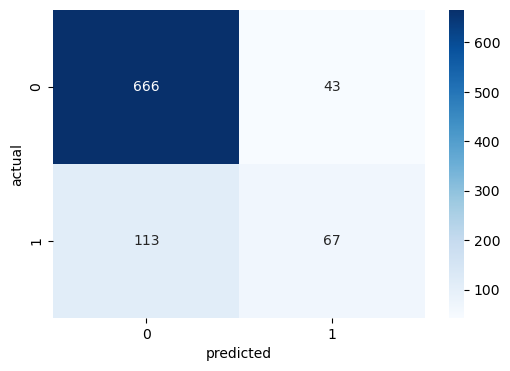

In [15]:
xgb_analysis(X_train,y_train,X_test,y_test)

We observe the same behaviour seen above with the ACC data. As before, the model shows clear overfitting, with training accuracy much higher than test accuracy, indicating limited generalization to unseen data.

The confusion matrix further highlights that the model often misclassifies non-diabetic individuals as diabetic, resulting in a high number of false positives. While less dangerous than false negatives, these errors could lead to unnecessary testing or treatment. Addressing this issue should be a focus in future model improvements.

In [16]:
#reshape features
X_train_cnn = X_train.reshape(-1, 20, 20, 1)
X_test_cnn  = X_test.reshape(-1, 20, 20, 1)

#create simple cnn
model = Sequential()
model.add(Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(20,20,1)))  #conv layer
model.add(Conv2D(32, kernel_size=(3,3), activation='relu'))  #conv layer
model.add(Flatten())                                                               #flatten to vector
model.add(Dense(64, activation='relu'))                                            #fully connected
model.add(Dense(1, activation='sigmoid'))                                         #output layer (2 classes)

#compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

#train model
model.fit(X_train_cnn, y_train, epochs=10, batch_size=32)

#evaluate
_, accuracy = model.evaluate(X_train_cnn, y_train)
print('Train accuracy =', accuracy)
_, accuracy = model.evaluate(X_test_cnn, y_test)
print('Test accuracy =', accuracy)

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - accuracy: 0.7763 - loss: 0.5479
Epoch 2/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.7799 - loss: 0.5129
Epoch 3/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.8127 - loss: 0.4302
Epoch 4/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.8240 - loss: 0.3986
Epoch 5/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.8545 - loss: 0.3662
Epoch 6/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.8556 - loss: 0.3415
Epoch 7/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.8788 - loss: 0.3087
Epoch 8/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.8643 - loss: 0.3281
Epoch 9/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - accuracy: 0.8719 - loss: 0.3209
Epoch 10/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.8755 - loss: 0.3056
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7707 - loss: 0.4890
Train accuracy = 0.8832858800888062
28/28 ━━━━━━━━━━━━

Since the DPC data are represented as 20×20 matrices, we evaluated the performance of a convolutional neural network (CNN), which is well-suited to capturing spatial patterns in matrix-structured data. Compared to the previous XGBoost analysis, the CNN achieves a slightly lower test accuracy; however, it exhibits a marked reduction in overfitting, as evidenced by a smaller gap between training and test performance.

This improvement suggests that the CNN is able to generalize better to unseen data, learning the underlying structure of the DPC matrices rather than simply memorizing the training examples. Overall, these results indicate that the CNN is a more appropriate model for this type of data, effectively balancing predictive performance and generalization capacity.

## Analysis on PSSM

In [17]:
#load train and test data
train = load('et_tp.PSSM.train')
test = load('et_tp.PSSM.test')

X_train = train.iloc[:,:-1]
y_train = train.iloc[:,-1]
X_test = test.iloc[:,:-1]
y_test = test.iloc[:,-1]

#convert target to integers
y_train = y_train.astype(int)
y_test = y_test.astype(int)

Train accuracy = 1.0
Test accuracy = 0.8946796959826275


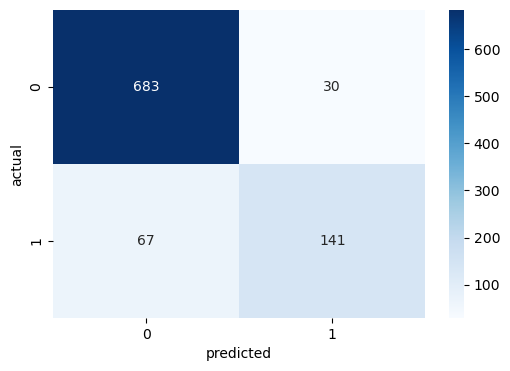

In [18]:
xgb_analysis(X_train,y_train,X_test,y_test)

The PSSM data appear to be the most informative for this problem, likely due to their higher complexity and richer representation of the protein sequences. Using these features, the model achieves the highest accuracy compared to previous analyses with AAC or DPC data.

Moreover, the confusion matrix confirms this improvement, showing a larger number of correctly classified diabetic and non-diabetic patients. This indicates that the model is better able to capture the relevant patterns in the PSSM matrices, effectively distinguishing between the two classes. Overall, the results suggest that PSSM features provide the most discriminative power for predicting diabetes in this dataset, highlighting the importance of using richer sequence-derived representations for complex biological prediction tasks.